# 🌀 Augmentations composition

`serket` comes with number of layers under the `image` subpackage to augment images. In this guide, a simple demonstration of composable augmentations is shown. Specifically, `jax.vmap` will be used to contstruct:

- One-to-many augmentations.
- Many-to-one augmentations.

In [ ]:
!pip install git+https://github.com/ASEM000/serket --quiet

## Imports

(-0.5, 255.5, 255.5, -0.5)

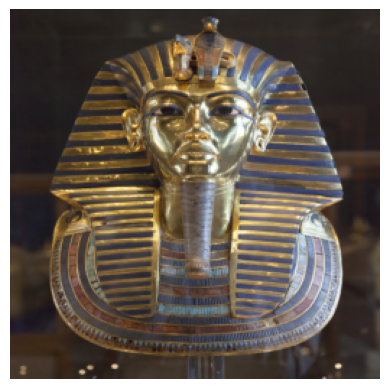

In [37]:
import serket as sk
import imageio
import jax
import jax.numpy as jnp
import jax.random as jr
from itertools import product
from matplotlib import pyplot as plt

url = "https://upload.wikimedia.org/wikipedia/commons/2/27/CairoEgMuseumTaaMaskMostlyPhotographed.jpg"

to_channel_last = lambda x: x.transpose(1, 2, 0)

tut = imageio.v2.imread(url).astype(jnp.float32) / 255.0
tut = tut.transpose(2, 0, 1)  # [H, W, C] -> [C, H, W]
tut = jax.image.resize(tut, shape=(3, 256, 256), method="bilinear")

plt.imshow(to_channel_last(tut))
plt.axis("off")

## Augmentation composition

(-0.5, 255.5, 255.5, -0.5)

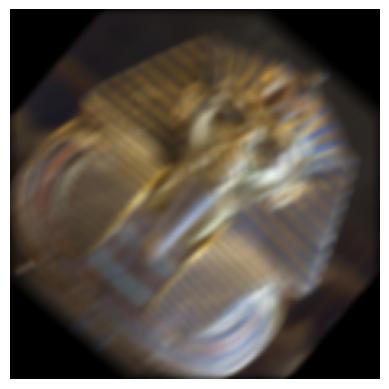

In [31]:
net = sk.Sequential(
    # lets start with random flips
    sk.image.RandomHorizontalFlip2D(rate=0.5),
    sk.image.RandomVerticalFlip2D(rate=0.5),
    # then random rotations between -45 and 45 degrees
    sk.image.RandomRotate2D((-45, 45)),
    # then random shearing between -30 and 30 degrees
    sk.image.RandomVerticalShear2D((-30, 30)),
    # lets add some blur with a 50% chance
    sk.image.GaussianBlur2D(kernel_size=5, sigma=(0.1, 2.0)),
    # and some motion blur, lets use FFT for large kernels
    sk.image.FFTMotionBlur2D(kernel_size=15, angle=30),
)

tut_aug = net(tut, key=jr.PRNGKey(0))
tut_aug = (tut_aug * 255).astype(jnp.uint8)
plt.imshow(to_channel_last(tut_aug))
plt.axis("off")

## One-to-many augmentations

Using `jax.vmap`, one-to-many augmentations can be made by vectorizing over the RNG key. The following code demonstrate this.

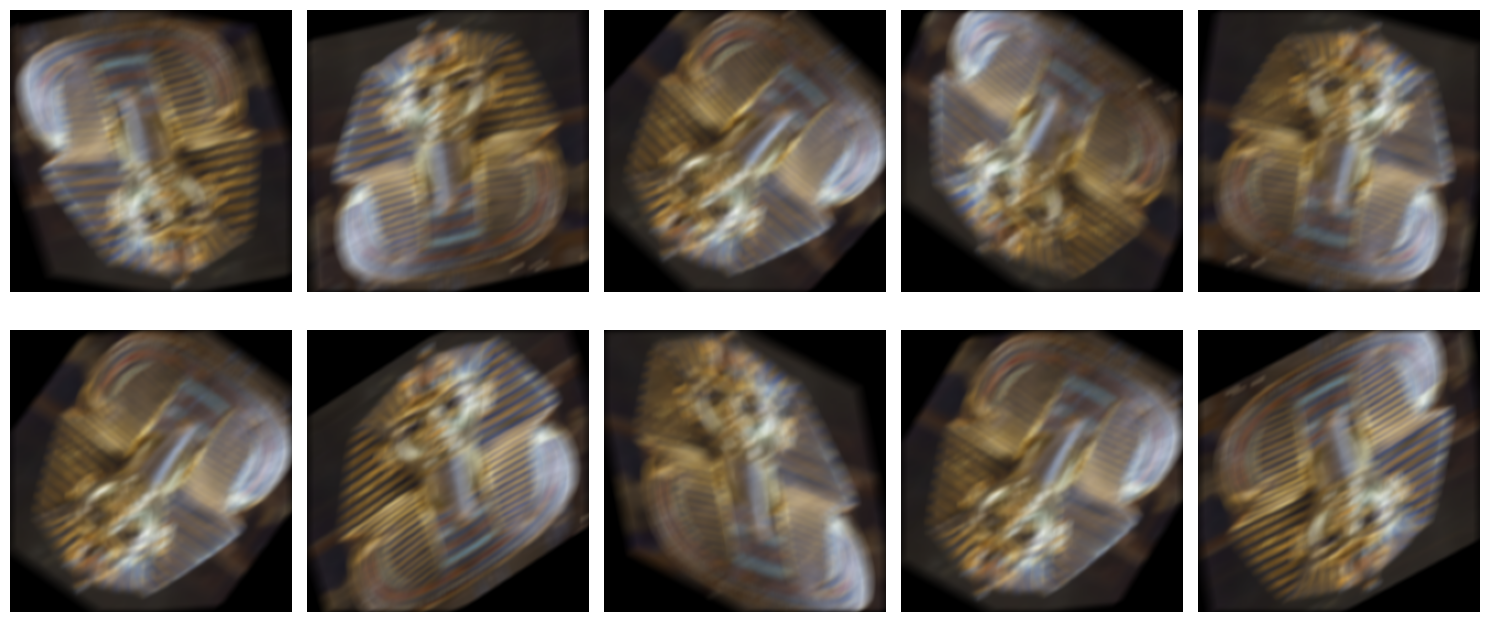

In [32]:
# lets create 10 different augmented images from the same image
keys = jr.split(jr.PRNGKey(1), 10)
tut_augs = jax.vmap(lambda key: net(tut, key=key))(keys)
tut_augs = (tut_augs * 255).astype(jnp.uint8)

fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    ax.imshow(to_channel_last(tut_augs[i]))
    ax.axis("off")
plt.tight_layout()

## Many-to-many augmentation

In case augmentation is done on multiple images,then `jax.vmap` is used to vectorize over images and keys to create unique augmentation for each image.

In this example for each image 5 augmentation is done.

In [63]:
# load first image
url = "https://upload.wikimedia.org/wikipedia/commons/2/27/CairoEgMuseumTaaMaskMostlyPhotographed.jpg"
tut = imageio.v2.imread(url).astype(jnp.float32) / 255.0
tut = tut.transpose(2, 0, 1)  # [H, W, C] -> [C, H, W]
tut = jax.image.resize(tut, shape=(3, 256, 256), method="bilinear")

# load second image
url = "https://upload.wikimedia.org/wikipedia/commons/1/1f/Nofretete_Neues_Museum.jpg"
nef = imageio.v2.imread(url).astype(jnp.float32) / 255.0
nef = nef.transpose(2, 0, 1)  # [H, W, C] -> [C, H, W]
nef = jax.image.resize(nef, shape=(3, 256, 256), method="bilinear")

# lets create a batch of the two images
batch = jnp.stack([tut, nef], axis=0)

# create a key for each image in the batch
keys = jr.split(jr.PRNGKey(1), len(batch))


@jax.jit
@jax.vmap
def many_to_many(image, key):
    # for each image in the batch, create 5 augmented images
    @jax.vmap
    def one_to_many_augmentation(key):
        return net(image, key=key)

    return one_to_many_augmentation(jr.split(key, 5))

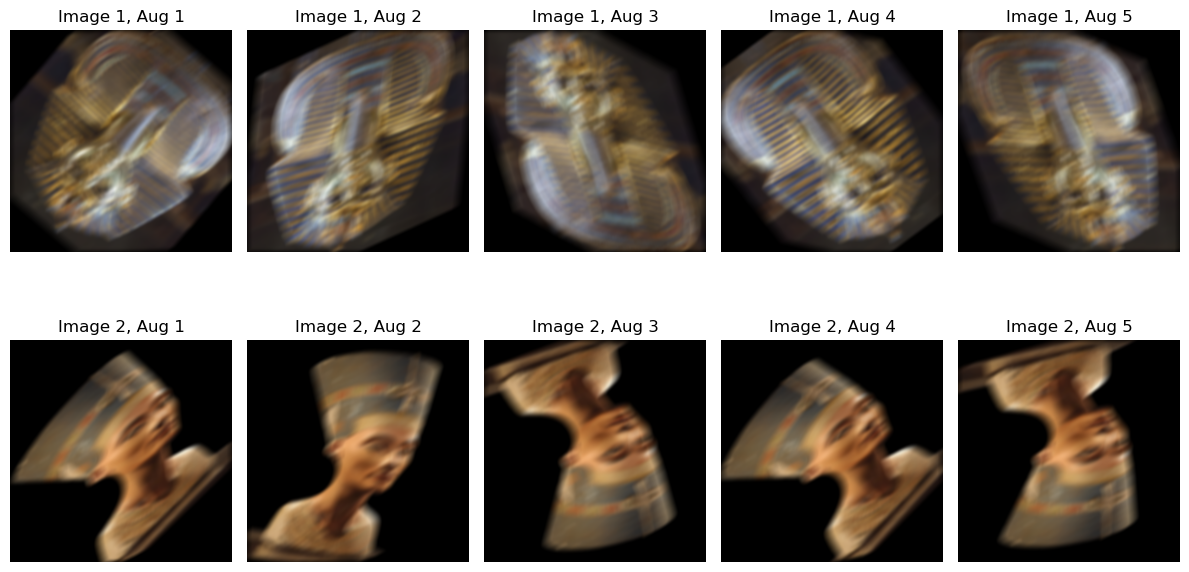

In [66]:
fig, axes = plt.subplots(2, 5, figsize=(12, 7))
tut_neg_augs = many_to_many(batch, keys)
for i, j in product(range(2), range(5)):
    axes[i, j].imshow(to_channel_last((tut_neg_augs[i, j]) * 255).astype(jnp.uint8))
    axes[i, j].axis("off")
    axes[i, j].set_title(f"Image {i+1}, Aug {j+1}")

plt.tight_layout()